# Turing Patterns

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from train_dynamics import FlowModel
from train_dynamics import load_score_model
from turing_pattern import GrayScottSimulator, create_random_state, TuringPatternDataset
from tqdm import tqdm

from training_free import training_free_flow, sde_solve
from visulization import TuringPlotter, plot_trace

# Set matplotlib to use STIX fonts for better LaTeX compatibility
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 10

In [60]:
def ground_truth_simulation(name, x0, T=500, dt=1.0):
    sim = GrayScottSimulator(pattern_preset=name, device='cuda', dt=dt)
    u, v = x0[0].unsqueeze(0), x0[1].unsqueeze(0)
    u, v = sim.forward(u, v, steps=1000, trace=True)
    trace_true = torch.cat([u, v], dim=0).permute(1,0,2,3).unsqueeze(1)
    return trace_true

In [110]:
# set random seed for reproducibility
torch.manual_seed(1)

sim_results = {}
gs_results = {}
for name in ['life', 'waves', 'spirals', 'maze']:
    f, score, dataset, scheduler = training_free_flow(name)
    x0 = dataset[0].cuda().unsqueeze(0)
    trace, trace_pred = sde_solve(f, score, scheduler, x0, 300, dt=0.01, eta=1, v_factor=1)
    sim_results[name] = dataset.denormalize(trace_pred)
    gs_results[name] = ground_truth_simulation(name, dataset.denormalize(x0)[0])

Dataset loaded from ./turing_pattern/data/life_128x128.pt
Pattern type: life
Parameters: Du=0.16, Dv=0.08, F=0.006, k=0.045
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:08<00:00, 37.45it/s]


Dataset loaded from ./turing_pattern/data/waves_128x128.pt
Pattern type: waves
Parameters: Du=0.16, Dv=0.08, F=0.018, k=0.049
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 46.72it/s]


Dataset loaded from ./turing_pattern/data/spirals_128x128.pt
Pattern type: spirals
Parameters: Du=0.16, Dv=0.08, F=0.007, k=0.028
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 44.71it/s]


Dataset loaded from ./turing_pattern/data/maze_128x128.pt
Pattern type: maze
Parameters: Du=0.16, Dv=0.08, F=0.029, k=0.057
Samples: 8192, Size: 128x128


100%|██████████| 300/300 [00:06<00:00, 48.37it/s]


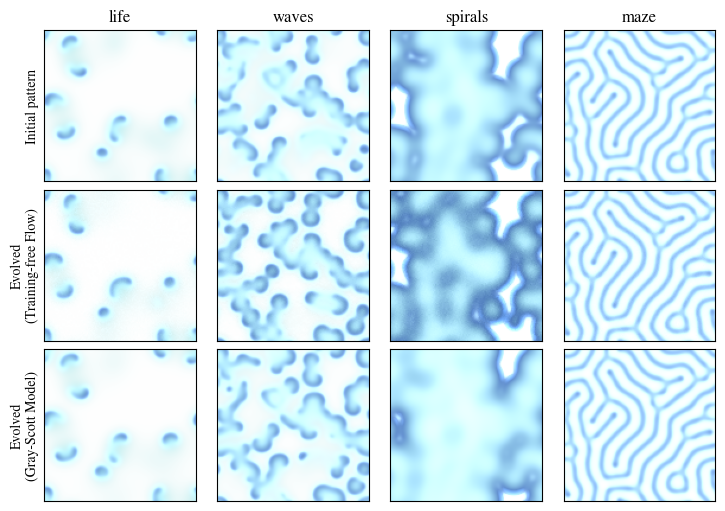

In [149]:
models = ['life', 'waves', 'spirals', 'maze']

fig = plt.figure(figsize=(7.2, 5), constrained_layout=True)
axs = fig.subplots(3, len(models), sharex=True, sharey=True)
plotter = TuringPlotter()

for i, name in enumerate(models):
    # 1. original
    plotter.plot(gs_results[name][0], name, ax=axs[0, i])
    axs[0, i].set_title(name)
    axs[0, i].set_xticks([]); axs[0, i].set_yticks([])
    if i == 0:
        axs[0, i].set_ylabel('Initial pattern')

    # 2. recovered
    plotter.plot(sim_results[name][200], name, ax=axs[1, i])
    if i == 0:
        axs[1, i].set_ylabel('Evolved\n(Training-free Flow)')

    # 3. ground-truth
    plotter.plot(gs_results[name][50], name, ax=axs[2, i])
    if i == 0:
        axs[2, i].set_ylabel('Evolved\n(Gray-Scott Model)')

plt.savefig('./figures/simulations.pdf', bbox_inches='tight')
plt.show()

# Uniqueness of Dynamics

In [159]:
e_truth = {}
e_sims = {}

models = ['life', 'waves', 'spirals', 'maze']

for name in models:
    e_sim = (sim_results[name][200] - sim_results[name][0]).reshape(-1)
    e_sim = e_sim / e_sim.norm()
    e_sims[name] = e_sim

    e_gs = (gs_results[name][50] - gs_results[name][0]).reshape(-1)
    e_gs = e_gs / e_gs.norm()
    e_truth[name] = e_gs

In [160]:
for n1 in e_sims.keys():
    for n2 in e_sims.keys():
        print(f'<{n1}, {n2}> = ', (e_sims[n1].cpu() @ e_sims[n2].cpu()).abs().item())

<life, life> =  1.000002145767212
<life, waves> =  0.08353292942047119
<life, spirals> =  0.025665832683444023
<life, maze> =  0.043731581419706345
<waves, life> =  0.08353292942047119
<waves, waves> =  1.0000016689300537
<waves, spirals> =  0.21929091215133667
<waves, maze> =  0.0188961960375309
<spirals, life> =  0.025665832683444023
<spirals, waves> =  0.21929091215133667
<spirals, spirals> =  1.000000238418579
<spirals, maze> =  0.02040599286556244
<maze, life> =  0.043731581419706345
<maze, waves> =  0.0188961960375309
<maze, spirals> =  0.02040599286556244
<maze, maze> =  1.0000005960464478


In [162]:
for n1 in e_sims.keys():
    for n2 in e_truth.keys():
        print(f'<{n1}, {n2}> = ', (e_sims[n1].cpu() @ e_truth[n2].cpu()).abs().item())

<life, life> =  0.21909277141094208
<life, waves> =  0.07882867008447647
<life, spirals> =  0.0072905514389276505
<life, maze> =  0.011744781397283077
<waves, life> =  0.14377911388874054
<waves, waves> =  0.6112182140350342
<waves, spirals> =  0.06138875335454941
<waves, maze> =  0.01406893227249384
<spirals, life> =  0.054265476763248444
<spirals, waves> =  0.10650751739740372
<spirals, spirals> =  0.1113499253988266
<spirals, maze> =  0.006169772706925869
<maze, life> =  0.04538019746541977
<maze, waves> =  0.005251916125416756
<maze, spirals> =  0.009671255946159363
<maze, maze> =  0.501663863658905


# Convolution Kernel

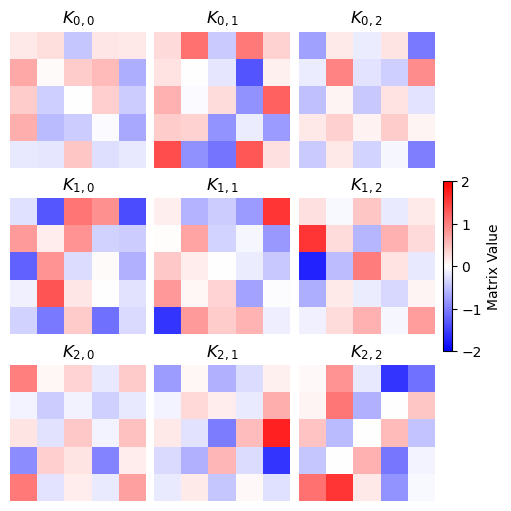

In [144]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

w = torch.randn(3,3, 5, 5)
k = (w - w.transpose(0,1).flip(-1, -2)) / 2

fig, axes = plt.subplots(k.shape[0], k.shape[1], figsize=(5,5), constrained_layout=True)
# norm = mpl.colors.Normalize(vmin=-3, vmax=3)
for o in range(k.shape[0]):
    for i in range(k.shape[1]):
        im = axes[o, i].imshow(k[o, i].cpu(), cmap='bwr', vmin=-2, vmax=2)
        axes[o, i].set_title(f'$K_{{{o},{i}}}$')
        axes[o, i].axis('off')

cbar = fig.colorbar(im, ax=axes, fraction=0.02, pad=0.02)
cbar.set_label('Matrix Value')
plt.savefig('./figures/kernel.pdf', bbox_inches='tight')
plt.show()